In [29]:
from pathlib import Path

import torch
import torchinfo
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from typing import Generator

from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchlake.image_generation.models.gan import (GANDiscriminator,
                                                   GANGenerator)
from torchlake.common.controller.recorder import TrainRecorder

# Setting

In [30]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [31]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [32]:
DEVICE = torch.device("cuda:0")

# Data

In [33]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [34]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [35]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

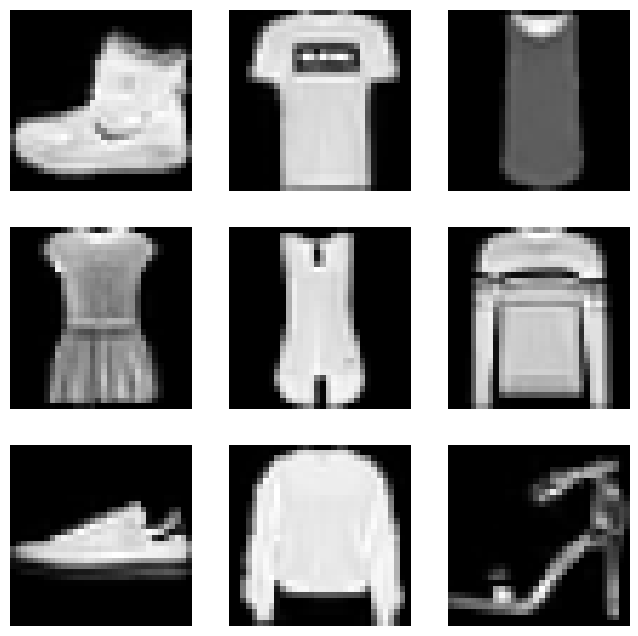

In [36]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [37]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [38]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [39]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
│    └─Unflatten: 2-9                    --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [40]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       524,800
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       131,328
│    └─LeakyReLU: 2-5                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [41]:
def noise_generator(batch_size: int) -> Generator[torch.Tensor, None, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [42]:
EPOCH = 30

In [43]:
trainer = GANTrainer(EPOCH, DEVICE)

In [44]:
trainer.set_discriminator_cycle(3)

In [45]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [46]:
LR = 1e-4
BETA = (0.5, 0.999)

In [47]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [48]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    criterion,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:28<00:00, 16.63it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 5.8261e-04 (0.00%)
generator: 3.0472e-02 (0.00%)


100%|██████████| 468/468 [00:25<00:00, 18.00it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 1.4580e-03 (150.00%)
generator: 5.3874e-02 (77.00%)


100%|██████████| 468/468 [00:26<00:00, 17.90it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 2.5410e-03 (74.00%)
generator: 7.1792e-02 (33.00%)


100%|██████████| 468/468 [00:27<00:00, 17.18it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 3.7340e-03 (47.00%)
generator: 8.9041e-02 (24.00%)


100%|██████████| 468/468 [00:27<00:00, 17.27it/s]


------------------------------------
Epoch 5
------------------------------------
discriminator: 5.1317e-03 (37.00%)
generator: 1.0378e-01 (17.00%)


100%|██████████| 468/468 [00:28<00:00, 16.41it/s]


------------------------------------
Epoch 6
------------------------------------
discriminator: 6.6718e-03 (30.00%)
generator: 1.1718e-01 (13.00%)


100%|██████████| 468/468 [00:27<00:00, 17.20it/s]


------------------------------------
Epoch 7
------------------------------------
discriminator: 8.1636e-03 (22.00%)
generator: 1.3054e-01 (11.00%)


100%|██████████| 468/468 [00:28<00:00, 16.40it/s]


------------------------------------
Epoch 8
------------------------------------
discriminator: 9.6368e-03 (18.00%)
generator: 1.4446e-01 (11.00%)


100%|██████████| 468/468 [00:26<00:00, 17.84it/s]


------------------------------------
Epoch 9
------------------------------------
discriminator: 1.1396e-02 (18.00%)
generator: 1.6092e-01 (11.00%)


100%|██████████| 468/468 [00:28<00:00, 16.50it/s]


------------------------------------
Epoch 10
------------------------------------
discriminator: 1.3370e-02 (17.00%)
generator: 1.8043e-01 (12.00%)


100%|██████████| 468/468 [00:28<00:00, 16.47it/s]


------------------------------------
Epoch 11
------------------------------------
discriminator: 1.5498e-02 (16.00%)
generator: 2.0188e-01 (12.00%)


100%|██████████| 468/468 [00:27<00:00, 16.95it/s]


------------------------------------
Epoch 12
------------------------------------
discriminator: 1.7779e-02 (15.00%)
generator: 2.2215e-01 (10.00%)


100%|██████████| 468/468 [00:27<00:00, 17.02it/s]


------------------------------------
Epoch 13
------------------------------------
discriminator: 2.0152e-02 (13.00%)
generator: 2.4081e-01 (8.00%)


100%|██████████| 468/468 [00:26<00:00, 17.57it/s]


------------------------------------
Epoch 14
------------------------------------
discriminator: 2.2656e-02 (12.00%)
generator: 2.5952e-01 (8.00%)


100%|██████████| 468/468 [00:28<00:00, 16.41it/s]


------------------------------------
Epoch 15
------------------------------------
discriminator: 2.5185e-02 (11.00%)
generator: 2.7741e-01 (7.00%)


100%|██████████| 468/468 [00:26<00:00, 17.51it/s]


------------------------------------
Epoch 16
------------------------------------
discriminator: 2.7761e-02 (10.00%)
generator: 2.9503e-01 (6.00%)


100%|██████████| 468/468 [00:27<00:00, 17.09it/s]


------------------------------------
Epoch 17
------------------------------------
discriminator: 3.0411e-02 (10.00%)
generator: 3.1223e-01 (6.00%)


100%|██████████| 468/468 [00:26<00:00, 17.82it/s]


------------------------------------
Epoch 18
------------------------------------
discriminator: 3.3098e-02 (9.00%)
generator: 3.2887e-01 (5.00%)


100%|██████████| 468/468 [00:28<00:00, 16.33it/s]


------------------------------------
Epoch 19
------------------------------------
discriminator: 3.5888e-02 (8.00%)
generator: 3.4514e-01 (5.00%)


100%|██████████| 468/468 [00:24<00:00, 19.07it/s]


------------------------------------
Epoch 20
------------------------------------
discriminator: 3.8680e-02 (8.00%)
generator: 3.6087e-01 (5.00%)


100%|██████████| 468/468 [00:24<00:00, 18.83it/s]


------------------------------------
Epoch 21
------------------------------------
discriminator: 4.1646e-02 (8.00%)
generator: 3.7586e-01 (4.00%)


100%|██████████| 468/468 [00:25<00:00, 18.63it/s]


------------------------------------
Epoch 22
------------------------------------
discriminator: 4.4668e-02 (7.00%)
generator: 3.9063e-01 (4.00%)


100%|██████████| 468/468 [00:26<00:00, 17.87it/s]


------------------------------------
Epoch 23
------------------------------------
discriminator: 4.7695e-02 (7.00%)
generator: 4.0524e-01 (4.00%)


100%|██████████| 468/468 [00:28<00:00, 16.59it/s]


------------------------------------
Epoch 24
------------------------------------
discriminator: 5.0815e-02 (7.00%)
generator: 4.1920e-01 (3.00%)


100%|██████████| 468/468 [00:28<00:00, 16.71it/s]


------------------------------------
Epoch 25
------------------------------------
discriminator: 5.4032e-02 (6.00%)
generator: 4.3272e-01 (3.00%)


100%|██████████| 468/468 [00:28<00:00, 16.59it/s]


------------------------------------
Epoch 26
------------------------------------
discriminator: 5.7302e-02 (6.00%)
generator: 4.4584e-01 (3.00%)


100%|██████████| 468/468 [00:27<00:00, 16.90it/s]


------------------------------------
Epoch 27
------------------------------------
discriminator: 6.0624e-02 (6.00%)
generator: 4.5877e-01 (3.00%)


100%|██████████| 468/468 [00:27<00:00, 16.79it/s]


------------------------------------
Epoch 28
------------------------------------
discriminator: 6.3933e-02 (5.00%)
generator: 4.7170e-01 (3.00%)


100%|██████████| 468/468 [00:27<00:00, 16.97it/s]


------------------------------------
Epoch 29
------------------------------------
discriminator: 6.7274e-02 (5.00%)
generator: 4.8422e-01 (3.00%)


100%|██████████| 468/468 [00:27<00:00, 17.00it/s]

------------------------------------
Epoch 30
------------------------------------
discriminator: 7.0669e-02 (5.00%)
generator: 4.9671e-01 (3.00%)


# evaluation

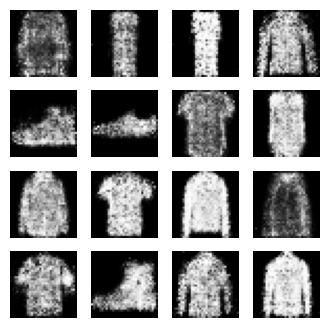

In [56]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [50]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:12<00:00, 38.96it/s]

0.71785


In [51]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:12<00:00, 36.29it/s]

0.19933333333333333


In [52]:
model_path = artifact_path / 'gan.pth'

In [53]:
torch.save(generator.state_dict(), model_path.as_posix())

In [54]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>